In [99]:
# Standard libraries
import sys
# Add your custom path
gems_tco_path = "/Users/joonwonlee/Documents/GEMS_TCO-1/src"
sys.path.append(gems_tco_path)
import logging
import argparse # Argument parsing

# Data manipulation and analysis
import pandas as pd
import numpy as np
import pickle
import torch
import torch.optim as optim
import copy                    # clone tensor
import time

# Custom imports
import GEMS_TCO
from GEMS_TCO import kernels

from GEMS_TCO import kernels 
from GEMS_TCO import orderings as _orderings 
from GEMS_TCO import load_data
from GEMS_TCO import alg_optimization, alg_opt_Encoder
from GEMS_TCO import configuration as config

from typing import Optional, List, Tuple
from pathlib import Path
import typer
import json
from json import JSONEncoder

from GEMS_TCO import configuration as config
from GEMS_TCO import data_preprocess as dmbh

import os
from sklearn.neighbors import BallTree

## Load data (but this version has latitude calibration)

In [2]:
# initialization
space = ['1,1']  # lat, lon resolution
days = ['0,31']
mm_cond_number = 20
lat_lon_resolution = [int(s) for s in space[0].split(',')]
days_s_e = list(map(int, days[0].split(',')))
print(days_s_e)

days_list = list(range(days_s_e[0], days_s_e[1]))
years = ['2024']
month_range =[7,8]
output_path = input_path = Path(config.mac_estimates_day_path)

## load ozone data from amarel
data_load_instance = load_data(config.mac_data_load_path)
df_map, ord_mm, nns_map= data_load_instance.load_mm20k_data_bymonthyear(lat_lon_resolution = lat_lon_resolution, mm_cond_number=mm_cond_number,years_=years, months_=month_range)  

# only fit spline once because space are all same
# load first data of analysis_data_map and aggregated_data to initialize spline_instance
first_day_idx_for_datamap= [0,8]
first_day_analysis_data_map, first_day_aggregated_data = data_load_instance.load_working_data_byday(df_map, ord_mm, nns_map, idx_for_datamap= first_day_idx_for_datamap)

[0, 31]


## Load data and undo latitude calibration

In [103]:
keys = list(df_map.keys())
df = df_map[keys[0]]

lon_s = 123
lon_e = 133
step_lat = 0.044
step_lon = 0.063

lat_coords = np.arange( 5 -0.044- 0.0002, 0 -0.044, -0.044)
lon_coords = np.arange( lon_e-step_lon- 0.0002, lon_s-step_lon, -step_lon)

# Apply the shift as in the original code
# These are the unique lat/lon values for the "center_points" grid
final_lat_values = lat_coords + step_lat 
final_lon_values = lon_coords + step_lon 

# Create 2D grid with broadcasting
#decrement = 0.00012
decrement = 0 
lat_grid = final_lat_values[:, None] + np.arange(len(final_lon_values)) * decrement  # shape: (228, 152)


mac_data_path = config.mac_data_load_path
years = [2024]  # years = [2023,2024]
months = list( range(7,8))
year = years[0]
month = months[0]
month_str = f"{month:02d}"  
filename = f"pickle_2024/orbit_map{str(year)[2:]}_{month_str}.pkl"
picklefile_path = Path(mac_data_path) / filename
print(picklefile_path)

with open(picklefile_path, 'rb') as pickle_file:
    data_map_hour = pickle.load(pickle_file)

# Base file path and settings
# base_path = "C:\\Users\\joonw\\TCO\\GEMS_data"    MSI notebook

mac_data_path = config.mac_data_load_path
lat_start, lat_end, lon_start, lon_end = 0, 5, 123, 133
step_lat, step_lon = 0.044, 0.063

# df = pd.read_csv("C:\\Users\\joonw\\TCO\\GEMS_data\\data_2024\\data_24_07_0131_N510_E110120.csv")  MSI notebook
df = pd.read_csv("/Users/joonwonlee/Documents/GEMS_DATA/data_2024/data_24_07_0131_N05_E123133.csv")  # MAC


/Users/joonwonlee/Documents/GEMS_DATA/pickle_2024/orbit_map24_07.pkl


In [104]:
class center_matching_hour():
    """
    Processes orbit data by averaging over specified spatial regions and resolutions.

    Parameters:
        df (pd.DataFrame): Input DataFrame containing the data.
        lat_s (int): Start latitude for spatial averaging.
        lat_e (int): End latitude for spatial averaging.
        lon_s (int): Start longitude for spatial averaging.
        lon_e (int): End longitude for spatial averaging.
        lat_resolution (Optional[float]): Latitude resolution for spatial bins. Default is None.
        lon_resolution (Optional[float]): Longitude resolution for spatial bins. Default is None.
    """
    def __init__(
        self, 
        df:pd.DataFrame=None, 
        lat_s:float =0,
        lat_e:float =5, 
        lon_s:float =123,
        lon_e:float =133, 
        lat_resolution:float=None, 
        lon_resolution:float =None
    ):
        # Input validation
        if df is not None:
            assert isinstance(df, pd.DataFrame), "df must be a pandas DataFrame"

        if lat_resolution is not None:
            assert isinstance(lat_resolution, float), "lat_resolution must be a float"
        if lon_resolution is not None:
            assert isinstance(lon_resolution, float), "lon_resolution must be a float"
        
        self.df = df
        self.lat_resolution = lat_resolution
        self.lon_resolution = lon_resolution
        self.lat_s = lat_s
        self.lat_e = lat_e
        self.lon_s = lon_s
        self.lon_e = lon_e

    def group_data_by_orbits(self):
        """
        Groups data into a dictionary based on unique orbit timestamps.

        Returns:
            dict: A dictionary where keys represent formatted orbit identifiers 
                and values are DataFrames corresponding to each orbit.
        """
        orbit_map = {}  
        self.df['Orbit'] = self.df['Time'].str[0:16]
        orbits = self.df['Orbit'].unique()
        for orbit in orbits:
            orbit_key = f'y{orbit[2:4]}m{int(orbit[5:7]):02d}day{ int(orbit[8:10]):02d}_hm{(orbit[11:16])}'
            orbit_map[orbit_key] = self.df.loc[self.df['Orbit'] == orbit].reset_index(drop=True)
        return orbit_map
    
    def make_center_points(self, step_lat:float=0.042, step_lon:float=0.062) -> pd.DataFrame:
        lat_coords = np.arange( self.lat_e-step_lat- 0.0002, self.lat_s -step_lat, -step_lat)
        lon_coords = np.arange( self.lon_e-step_lon- 0.0002, self.lon_s-step_lon, -step_lon)

        # Apply the shift as in the original code
        # These are the unique lat/lon values for the "center_points" grid
        final_lat_values = lat_coords + step_lat 
        final_lon_values = lon_coords + step_lon 
        
        # Create 2D grid with broadcasting
        #decrement = 0.00012
        decrement = 0
        lat_grid = final_lat_values[:, None] + np.arange(len(final_lon_values)) * decrement  # shape: (228, 152)

        # Flatten row-wise (C order)
        center_lats = lat_grid.flatten()

        # Create matching longitude grid
        center_lons = np.tile(final_lon_values, len(final_lat_values))

        # Now you can build your DataFrame
        center_points_df = pd.DataFrame({'lat': center_lats, 'lon': center_lons})
        return center_points_df
    

    '''  
    coarse_by_center   allows duplicates while coarse_by_center_unique doesnt.
    '''

    def coarse_by_center(self, orbit_map: dict, center_points: pd.DataFrame) -> dict:
        assert isinstance(orbit_map, dict), "orbit_map must be a dict"
        assert isinstance(center_points, pd.DataFrame), "center_points must be a pd.DataFrame"

        coarse_map = {}
        key_list = sorted(orbit_map)

        # Convert query points (lat, lon) to NumPy array
        query_points = center_points[['lat', 'lon']].to_numpy()
        query_points_rad = np.radians(query_points)  # if using haversine

        num_center_points = len(center_points)

        for key in key_list:
            cur_data = orbit_map[key].reset_index(drop=True)
            locs = cur_data[['Latitude', 'Longitude']].to_numpy()

            if locs.shape[0] == 0:
                coarse_map[key] = pd.DataFrame({
                    'Latitude': center_points['lat'],
                    'Longitude': center_points['lon'],
                    'ColumnAmountO3': [np.nan] * num_center_points,
                    'Hours_elapsed': [np.nan] * num_center_points,
                    'Time': [pd.NaT] * num_center_points,
                    'Source_Latitude': [np.nan] * num_center_points,
                    'Source_Longitude': [np.nan] * num_center_points
                })
                continue

            # Use haversine
            locs_rad = np.radians(locs)
            tree = BallTree(locs_rad, metric='haversine')
            dist, ind = tree.query(query_points_rad, k=1)

            nearest_indices = ind.flatten()

            # Extract values from the nearest source points
            res_o3_values = cur_data.loc[nearest_indices, 'ColumnAmountO3'].values
            source_lat = cur_data.loc[nearest_indices, 'Latitude'].values
            source_lon = cur_data.loc[nearest_indices, 'Longitude'].values

            hours_elapsed_val = cur_data['Hours_elapsed'].iloc[0] if not cur_data.empty else np.nan
            time_val = cur_data['Time'].iloc[0] if not cur_data.empty else pd.NaT

            coarse_map[key] = pd.DataFrame({
                'Latitude': center_points['lat'].values,
                'Longitude': center_points['lon'].values,
                'ColumnAmountO3': res_o3_values,
                'Hours_elapsed': [hours_elapsed_val] * num_center_points,
                'Time': [time_val] * num_center_points,
                'Source_Latitude': source_lat,
                'Source_Longitude': source_lon
            })
        return coarse_map

In [105]:
instance = center_matching_hour(df, lat_start, lat_end, lon_start, lon_end)  

for year in years:        # years = [2023,2024]
    for month in months:  
        try:
            # load pickle (dense ORI data)
            pickle_path = os.path.join(mac_data_path, f'pickle_{year}')
            input_filename = f"orbit_map{str(year)[2:]}_{month_str}.pkl"
            input_filepath = os.path.join(pickle_path, input_filename)
            with open(input_filepath, 'rb') as pickle_file:
                loaded_map = pickle.load(pickle_file)
            center_points = instance.make_center_points(step_lat = step_lat, step_lon= step_lon)
            coarse_cen_map = instance.coarse_by_center(loaded_map, center_points)

            # Save pickle (coarse data)
            output_filename = f"coarse_cen_map_without_decrement_latitude{str(year)[2:]}_{month_str}.pkl"
            output_filepath = os.path.join(pickle_path, output_filename)
            with open(output_filepath, 'wb') as pickle_file:
                pickle.dump(coarse_cen_map, pickle_file)
            
            print(f"Successfully processed and saved data for year {str(year)[2:]} month {month_str}.")
        except FileNotFoundError:
            print(f"Warning: File {input_filename} not found. Skipping.")
        except Exception as e:
            print(f"Error processing file {input_filename}: {e}")

Successfully processed and saved data for year 24 month 07.


In [107]:
pickle_path = os.path.join(mac_data_path, f'pickle_{year}')
output_filename = f"coarse_cen_map_without_decrement_latitude{str(year)[2:]}_{month_str}.pkl"
output_filepath = os.path.join(pickle_path, output_filename)

with open(output_filepath, 'rb') as pickle_file:
    cbmap_ori = pickle.load(pickle_file)

day1_df_ori = pd.concat(cbmap_ori.values(), axis=0, ignore_index=True)


## Compute C_{g,n}(u)

In [122]:
import numpy as np
import pandas as pd
from scipy.signal import convolve2d

def apply_laplacian_2d_valid(df: pd.DataFrame) -> pd.DataFrame:
    """
    Applies a 2D discrete Laplacian filter using 'mode=valid', returning a new,
    smaller DataFrame with the cropped results and corresponding coordinates.

    Args:
        df (pd.DataFrame): A DataFrame for a single time slice, containing
                           'ColumnAmountO3', 'Latitude', and 'Longitude' columns.

    Returns:
        pd.DataFrame: A new, smaller DataFrame containing the 'laplacian' values
                      and the corresponding 'Latitude', 'Longitude', and 'Time'.
    """
    # Dynamically determine the grid shape and unique coordinates
    unique_lats = df['Latitude'].unique()
    unique_lons = df['Longitude'].unique()
    lat_count = len(unique_lats)
    lon_count = len(unique_lons)
    
    if df.shape[0] != lat_count * lon_count:
        raise ValueError("DataFrame size does not match the grid dimensions (lat * lon).")

    # Reshape the data based on its flattening order (lat slowest, lon fastest)
    grid = df['ColumnAmountO3'].values.reshape((lat_count, lon_count))

    # Define the standard 3x3 discrete Laplacian kernel
    laplacian_kernel = np.array([[0, 1, 0],
                                 [1, -4, 1],
                                 [0, 1, 0]])

    # Apply convolution with 'valid' mode, which crops the boundaries.
    laplacian_grid_cropped = convolve2d(grid, laplacian_kernel, mode='valid')
    
    # Determine the new, cropped coordinates. A 3x3 kernel removes one
    # element from each of the four sides.
    cropped_lats = unique_lats[1:-1]
    cropped_lons = unique_lons[1:-1]

    # If cropping results in an empty grid, return an empty DataFrame
    if len(cropped_lats) == 0 or len(cropped_lons) == 0:
        return pd.DataFrame()

    # Create a new meshgrid for the cropped coordinates
    new_lon_grid, new_lat_grid = np.meshgrid(cropped_lons, cropped_lats)
    
    # Create the new DataFrame with the filtered data and new coordinates
    new_df = pd.DataFrame({
        'Latitude': new_lat_grid.flatten(),
        'Longitude': new_lon_grid.flatten(),
        'laplacian': laplacian_grid_cropped.flatten()
    })
    
    # Preserve the timestamp from the original slice if it exists
    if 'Time' in df.columns:
        new_df['Time'] = df['Time'].iloc[0]
        
    new_df['Hours_elapsed'] = df['Hours_elapsed'].iloc[0]

    return new_df

def subset(df):
    """Subsets the DataFrame to a specific lat/lon range, as provided."""
    tmp = df['Longitude'].unique().copy()
    tmp2 = tmp[(tmp >= 123.5) & (tmp <= 132)]
    lon_cut = tmp2[5:]
    t = df['Latitude'].unique().copy()
    t2 = t[(t >= 0) & (t <= 3)]
    lat_cut = t2[2:]
    # Ensure that lat_cut and lon_cut are not empty to avoid errors
    if len(lon_cut) == 0 or len(lat_cut) == 0:
        return pd.DataFrame(columns=df.columns) # Return empty DF if no data
    df_sub = df[(df['Longitude'].isin(lon_cut)) & (df['Latitude'].isin(lat_cut))].reset_index(drop=True)
    return df_sub

# --- Example Usage ---
if __name__ == '__main__':


    a = list(cbmap_ori.keys())
    
    processed_dfs = []
    
    for k in a[:8]:
        print(f"  Processing key: {k}")
        
        cur = subset(cbmap_ori[k])
        
        if not cur.empty:
            # The function now returns a new, smaller DataFrame with the filtered data
            filtered_df = apply_laplacian_2d_valid(cur)
            if not filtered_df.empty:
                processed_dfs.append(filtered_df)

    # 3. Concatenate all processed (and now smaller) DataFrames
    if processed_dfs:
        final_df = pd.concat(processed_dfs, axis=0, ignore_index=True)
        
        print("\n--- Processing Complete ---")
        print("Final DataFrame shape:", final_df.shape)
        print("Columns:", final_df.columns)
        print("\nHead of the final DataFrame:")
        print(final_df.head())
        print("\nTail of the final DataFrame:")
        print(final_df.tail())
    else:
        print("\nProcessing resulted in an empty DataFrame.")

  Processing key: y24m07day01_hm00:52
  Processing key: y24m07day01_hm01:52
  Processing key: y24m07day01_hm02:52
  Processing key: y24m07day01_hm03:52
  Processing key: y24m07day01_hm04:48
  Processing key: y24m07day01_hm05:48
  Processing key: y24m07day01_hm06:48
  Processing key: y24m07day01_hm07:48

--- Processing Complete ---
Final DataFrame shape: (65536, 5)
Columns: Index(['Latitude', 'Longitude', 'laplacian', 'Time', 'Hours_elapsed'], dtype='object')

Head of the final DataFrame:
   Latitude  Longitude  laplacian                 Time  Hours_elapsed
0    2.8438   131.6138   -6.56543  2024-07-01 00:52:00  477720.866667
1    2.8438   131.5508   -3.03646  2024-07-01 00:52:00  477720.866667
2    2.8438   131.4878   20.61612  2024-07-01 00:52:00  477720.866667
3    2.8438   131.4248   -4.31279  2024-07-01 00:52:00  477720.866667
4    2.8438   131.3618   -1.02134  2024-07-01 00:52:00  477720.866667

Tail of the final DataFrame:
       Latitude  Longitude  laplacian                 Tim

In [143]:
lats = cur['Latitude'].unique()
lons = cur['Longitude'].unique()

# laplacian positions
positions = [ (lats[0], lons[1]), (lats[1],lons[0]), (lats[1], lons[2]), (lats[2],lons[1])  ]
print(positions)
tmp = 0 
for x,y in positions:
    tmp+= cur.loc[(cur['Latitude'] == x) & (cur['Longitude'] == y), 'ColumnAmountO3'].values[0]

tmp -= cur.loc[(cur['Latitude'] == lats[1]) & (cur['Longitude'] == lons[1]), 'ColumnAmountO3'].values[0]*4
tmp

print(lats[1], lons[1])

[(2.8878000000000195, 131.61380000000025), (2.84380000000002, 131.67680000000024), (2.84380000000002, 131.55080000000027), (2.7998000000000203, 131.61380000000025)]
2.84380000000002 131.61380000000025


In [137]:
final_df['Hours_elapsed'].unique()[7]

477727.8

In [145]:
df1 = final_df[ final_df['Hours_elapsed'] ==  final_df['Hours_elapsed'].unique()[7]].reset_index(drop=True)
df1['laplacian']

0        2.77747
1      -15.47635
2       -1.04339
3        0.72936
4       -5.38342
          ...   
8187     2.81470
8188     1.03326
8189    -3.56801
8190    -3.82671
8191     9.82056
Name: laplacian, Length: 8192, dtype: float64

In [ ]:
longitude_values = df1['Longitude'].unique()
latitude_values = df1['Latitude'].unique()

def cgn(u):
    u1,u2 = u
    return (1-np.abs(u1)/64)*(1-np.abs(u2)/128) 

u = (0,0)

cgn(u)

def cov_laplacian(u):
    u1,u2 = u
    delta1, delta2 = 0.044, 0.063
    directions = [ (0,1), (0,-1), (1,0), (-1,0)]
    cov = 0 
    for dx1, dy1 in directions:
        for dx2, dy2 in directions:
            cov += cov_x( (u1+dx1-dx2) * delta1, (u2+dy1-dy2) * delta2 )
    
    for dx1, dy1 in directions:
        cov -= 4 * cov_x( (u1+dx1) * delta1, (u2+dy1) * delta2 )
        cov -= 4 * cov_x( (u1-dx1) * delta1, (u2-dy1) * delta2 )
    
    cov += 16 * cov_x( u1 * delta1, u2 * delta2 )
    return cov

def cn_bar(u, params):
    return cov_laplacian(u) * cgn(u)

def compute_periodogram(process):
    """
    Computes the periodogram of a given process vector using FFT.

    Args:
        process (np.ndarray): The input time series vector.

    Returns:
        tuple: A tuple containing:
            - freqs (np.ndarray): The frequencies corresponding to the periodogram.
            - periodogram (np.ndarray): The computed periodogram values.
    """
    n = len(process)
    fft_result = np.fft.fft(process)
    # Calculate the squared magnitude of the FFT result
    # We take the absolute value and square it
    periodogram = (np.abs(fft_result)**2) / n
    # The frequencies corresponding to the FFT result
    # np.fft.fftfreq returns the frequencies for the given number of samples
    freqs = np.fft.fftfreq(n)

    return freqs, periodogram

def expected_periodogram(omega, params):
    d = 2
    n1, n2 = 64, 128
    delta1, delta2 = 0.044, 0.063
    sum_val = 0
    for u1 in range(0, n1-1):
        for u2 in range(0, n2-1):
            u = (u1, u2)
            tmp = cn_bar(u,u2, params) + cn_bar(u1-n1,u2-n2,[params]) + cn_bar(u1,u2-n2, params) + cn_bar(u1-n1,u2, params)
            sum_val +=  tmp* np.exp( -i*(omega[0]*u1*delta1 + omega[1]*u2*delta2) )
    return sum_val / (2* np.pi)** d

def likelihood(params, df):
    n1,n2 = 64, 128
    n = df.shape[0]
    likelihood = 0 
    for i in range( n1-1):
        for j in range(n2-1):
            exp_periodogram = expected_periodogram( omega, params)
            periodogram = compute_periodogram(omega)
            likelihood += np.log(exp_periodogram) + periodogram/ exp_periodogram
    
    return likelihood









1.0

In [70]:
times = final_df['Hours_elapsed'].unique()
cbmap = {}
for t in range(len(times)):
    cbmap[t] = final_df[final_df['Hours_elapsed'] == times[t]].reset_index(drop=True)

cbmap[0]
    

,Latitude,Longitude,laplacian,Time,Hours_elapsed
0,2.8438,131.6138,-6.56543,2024-07-01 00:52:00,477720.866667
1,2.8438,131.5508,-3.03646,2024-07-01 00:52:00,477720.866667
2,2.8438,131.4878,20.61612,2024-07-01 00:52:00,477720.866667
3,2.8438,131.4248,-4.31279,2024-07-01 00:52:00,477720.866667
4,2.8438,131.3618,-1.02134,2024-07-01 00:52:00,477720.866667
...,...,...,...,...,...
8187,0.0718,123.8648,7.24210,2024-07-01 00:52:00,477720.866667
8188,0.0718,123.8018,11.77049,2024-07-01 00:52:00,477720.866667
8189,0.0718,123.7388,5.04792,2024-07-01 00:52:00,477720.866667
8190,0.0718,123.6758,-8.77332,2024-07-01 00:52:00,477720.866667


# 2d fft

In [71]:
import pandas as pd
import numpy as np
from numpy import fft

def get_2d_ffts_from_dataframe(df: pd.DataFrame, data_column: str) -> np.ndarray:
    """
    Computes the 2D DFT for each time slice in a spatio-temporal DataFrame.
    """
    all_fft_coeffs = []
    
    # Get grid shape from the data
    lat_count = df['Latitude'].nunique()
    lon_count = df['Longitude'].nunique()
    grid_shape_2d = (lat_count, lon_count)

    # Iterate over each unique timestamp
    for time in df['Time'].unique():
        time_slice_df = df[df['Time'] == time]
        data_vector = time_slice_df[data_column].values
        grid_2d = data_vector.reshape(grid_shape_2d)
        fft_2d = fft.fft2(grid_2d)
        all_fft_coeffs.append(fft_2d.flatten())
    
    return np.concatenate(all_fft_coeffs)

def compute_2d_power_spectrum(covariance_func, grid_shape: tuple) -> np.ndarray:
    """
    Computes the theoretical 2D power spectrum from a stationary spatial covariance function.
    """
    n_lat, n_lon = grid_shape
    autocorr_grid = np.zeros(grid_shape)
    
    for i in range(n_lat):
        for j in range(n_lon):
            autocorr_grid[i, j] = covariance_func((i, j))
    
    power_spectrum_grid = fft.fft2(autocorr_grid)
    return power_spectrum_grid.flatten().real

# --- Example Usage ---
if __name__ == '__main__':

    
    # --- Part 1: Concatenate pre-processed data ---
    print("\n--- Part 1: Concatenating Pre-processed DataFrames ---")
    if not cbmap:
        print("Initial data map is empty. Exiting.")
    else:
        final_df = pd.concat(cbmap.values(), axis=0, ignore_index=True)
        print("Final DataFrame created from pre-processed data.")
        print("Shape:", final_df.shape)
        
        # --- Part 2: Apply 2D FFT to each time slice ---
        print("\n--- Part 2: Applying 2D FFT to Laplacian Data for each Time Slice ---")
        try:
            fft_coeffs = get_2d_ffts_from_dataframe(final_df, data_column='laplacian')
            final_df['laplacian_fft_2d'] = fft_coeffs
            
            print("Successfully calculated 2D FFT coefficients.")
            print(final_df[['Latitude', 'Longitude', 'Time', 'laplacian', 'laplacian_fft_2d']].head())
            
            # --- Part 3: Compute theoretical 2D power spectrum ---
            print("\n--- Part 3: Calculating Theoretical 2D Power Spectrum ---")
            
            filtered_lat_count = final_df['Latitude'].nunique()
            filtered_lon_count = final_df['Longitude'].nunique()
            filtered_grid_shape_2d = (filtered_lat_count, filtered_lon_count)
            print(f"Detected 2D grid shape: {filtered_grid_shape_2d}")

            def example_laplacian_cov_func_2d(disp):
                d_lat, d_lon = disp
                distance = np.sqrt(d_lat**2 + d_lon**2)
                return np.exp(-0.2 * distance)

            power_spectrum = compute_2d_power_spectrum(example_laplacian_cov_func_2d, filtered_grid_shape_2d)
            print(f"\nSuccessfully calculated theoretical 2D power spectrum of size {power_spectrum.size}.")
            print(f"First 5 power spectrum values: {power_spectrum[:5]}")
            
        except ValueError as e:
            print(f"\nAn error occurred during FFT processing: {e}")


--- Part 1: Concatenating Pre-processed DataFrames ---
Final DataFrame created from pre-processed data.
Shape: (65536, 5)

--- Part 2: Applying 2D FFT to Laplacian Data for each Time Slice ---
Successfully calculated 2D FFT coefficients.
   Latitude  Longitude                 Time  laplacian        laplacian_fft_2d
0    2.8438   131.6138  2024-07-01 00:52:00   -6.56543  220.687560+  0.000000j
1    2.8438   131.5508  2024-07-01 00:52:00   -3.03646   76.439582- 72.388203j
2    2.8438   131.4878  2024-07-01 00:52:00   20.61612  155.989037-  2.947171j
3    2.8438   131.4248  2024-07-01 00:52:00   -4.31279   77.383203-  3.500806j
4    2.8438   131.3618  2024-07-01 00:52:00   -1.02134  100.108286- 56.076958j

--- Part 3: Calculating Theoretical 2D Power Spectrum ---
Detected 2D grid shape: (64, 128)

Successfully calculated theoretical 2D power spectrum of size 8192.
First 5 power spectrum values: [44.54762499 41.10693604 33.19955321 24.90460615 18.32049334]


In [72]:
times = final_df['Hours_elapsed'].unique()
cbmap2 = {}
for t in range(len(times)):
    cbmap2[t] = final_df[final_df['Hours_elapsed'] == times[t]].reset_index(drop=True)

cbmap2[0]

,Latitude,Longitude,laplacian,Time,Hours_elapsed,laplacian_fft_2d
0,2.8438,131.6138,-6.56543,2024-07-01 00:52:00,477720.866667,220.687560+ 0.000000j
1,2.8438,131.5508,-3.03646,2024-07-01 00:52:00,477720.866667,76.439582- 72.388203j
2,2.8438,131.4878,20.61612,2024-07-01 00:52:00,477720.866667,155.989037- 2.947171j
3,2.8438,131.4248,-4.31279,2024-07-01 00:52:00,477720.866667,77.383203- 3.500806j
4,2.8438,131.3618,-1.02134,2024-07-01 00:52:00,477720.866667,100.108286- 56.076958j
...,...,...,...,...,...,...
8187,0.0718,123.8648,7.24210,2024-07-01 00:52:00,477720.866667,54.593950+ 43.545613j
8188,0.0718,123.8018,11.77049,2024-07-01 00:52:00,477720.866667,52.108573+ 74.003020j
8189,0.0718,123.7388,5.04792,2024-07-01 00:52:00,477720.866667,34.428401+ 30.592548j
8190,0.0718,123.6758,-8.77332,2024-07-01 00:52:00,477720.866667,49.235779+ 37.246096j


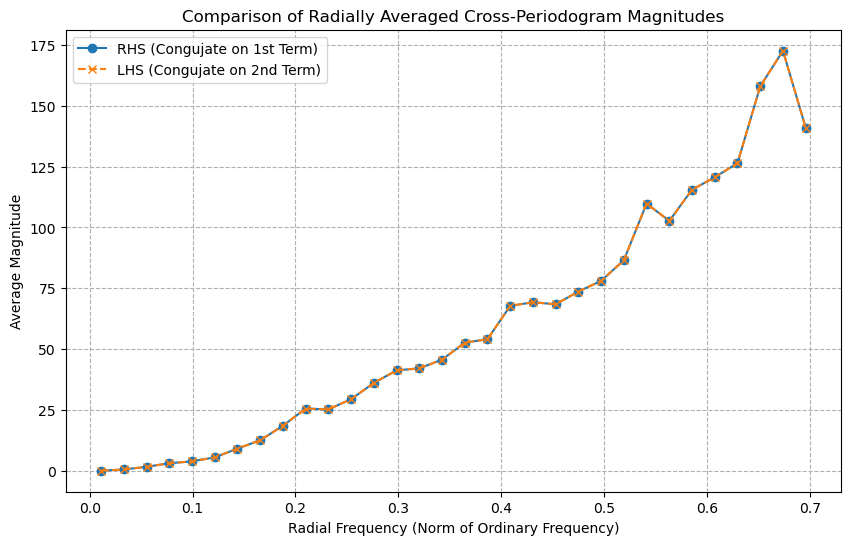

In [88]:
import numpy as np
import pandas as pd
from numpy import fft
import matplotlib.pyplot as plt

# The radially_average_cross_spectrum function remains the same as before
def radially_average_cross_spectrum(cross_periodogram_flat, rows, cols):
    """
    Computes the radial average of a flattened 2D cross-periodogram.
    """
    # 1. Reshape the flat data back into a 2D grid
    cross_periodogram_2d = cross_periodogram_flat.reshape(rows, cols)
    
    # 2. Shift the zero-frequency to the center.
    cross_periodogram_shifted = fft.fftshift(cross_periodogram_2d)
    
    # 3. Calculate the magnitude of the cross-spectrum
    magnitude_2d = np.abs(cross_periodogram_shifted)
    
    # 4. Create the radial frequency grid
    freq_rows = fft.fftshift(fft.fftfreq(rows))
    freq_cols = fft.fftshift(fft.fftfreq(cols))
    col_grid, row_grid = np.meshgrid(freq_cols, freq_rows)
    radial_freq_grid = np.sqrt(col_grid**2 + row_grid**2)
    
    # 5. Perform the averaging
    max_radius = np.max(radial_freq_grid)
    num_bins = min(rows, cols) // 2
    radial_bins = np.linspace(0, max_radius, num_bins + 1)
    
    magnitude_sum_in_bin, _ = np.histogram(
        radial_freq_grid,
        bins=radial_bins,
        weights=magnitude_2d
    )
    
    counts_in_bin, _ = np.histogram(
        radial_freq_grid,
        bins=radial_bins
    )
    
    average_magnitude = np.divide(
        magnitude_sum_in_bin,
        counts_in_bin,
        out=np.zeros_like(magnitude_sum_in_bin),
        where=(counts_in_bin != 0)
    )
    
    bin_centers = (radial_bins[:-1] + radial_bins[1:]) / 2
    
    return bin_centers, average_magnitude

# --- Example Usage ---
if __name__ == '__main__':
    # --- Setup ---
    GRID_ROWS, GRID_COLS = 64, 128
    N = GRID_ROWS * GRID_COLS
    

    # --- Computation ---
    fft_hour0 = cbmap2[6]['laplacian_fft_2d'].values
    fft_hour1 = cbmap2[7]['laplacian_fft_2d'].values

    # 1. Compute the "Right-Hand Side" (RHS) version (conjugate on the first term)
    cross_periodogram_rhs = (1/N) * np.conjugate(fft_hour0) * fft_hour1

    # 2. Compute the "Left-Hand Side" (LHS) version (conjugate on the second term)
    cross_periodogram_lhs = (1/N) * fft_hour0 * np.conjugate(fft_hour1)

    # 3. Radially average both results
    radial_freq_rhs, avg_mag_rhs = radially_average_cross_spectrum(
        cross_periodogram_rhs, GRID_ROWS, GRID_COLS
    )
    radial_freq_lhs, avg_mag_lhs = radially_average_cross_spectrum(
        cross_periodogram_lhs, GRID_ROWS, GRID_COLS
    )

    # --- Plotting ---
    plt.figure(figsize=(10, 6))
    
    # Plot both lines for comparison
    plt.plot(radial_freq_rhs, avg_mag_rhs, 'o-', label='RHS (Congujate on 1st Term)')
    plt.plot(radial_freq_lhs, avg_mag_lhs, 'x--', label='LHS (Congujate on 2nd Term)')
    
    plt.title("Comparison of Radially Averaged Cross-Periodogram Magnitudes")
    plt.xlabel("Radial Frequency (Norm of Ordinary Frequency)")
    plt.ylabel("Average Magnitude")
    plt.legend()
    plt.grid(True, which='both', linestyle='--')
    plt.show()

In [93]:
for j in range(7):
        
    fft_hour0 = cbmap2[j]['laplacian_fft_2d'].values
    fft_hour1 = cbmap2[j+1]['laplacian_fft_2d'].values

    # 1. Compute the "Right-Hand Side" (RHS) version (conjugate on the first term)
    cross_periodogram_rhs = (1/N) * np.conjugate(fft_hour0) * fft_hour1

    print(cross_periodogram_rhs[:10])
    print('cut here')

[ 0.70419725+0.00000000e+00j -0.64473882-6.63703586e-01j
  0.93621228+1.49463819e-01j -0.58381618+8.32016105e-02j
 -0.97425135+3.79818247e-01j  2.40510486-3.51297204e+00j
 -2.69454074+1.42657040e-03j -2.8397978 -1.67715608e+00j
  0.32943418-1.67980737e+00j  1.35032969+5.10693062e-01j]
cut here
[ 0.32904949+0.j          0.39395087+0.66305482j  0.33482216-0.14775469j
  0.3447862 -0.50644436j  0.26751758-0.77168488j  0.85652084-0.69434516j
  3.61226955-1.41114771j -0.01324809-0.45613345j -0.30800848+0.37745438j
  2.989671  -2.14600802j]
cut here
[ 3.33360085+0.j         -1.19439534+0.98723386j  1.21467754+0.7665036j
  0.33981995-1.48603698j  1.2529881 -1.618339j    0.75750263+0.34693849j
  1.25719417-4.52787787j -0.1990262 -0.4443119j   0.05141786-1.32662032j
 -0.61037715-4.30471103j]
cut here
[ 3.74678553+0.j          1.03206365-0.58823796j  1.91509571-0.00599558j
  1.59497965+0.33736544j -1.0599344 -0.48749349j  0.5337342 -1.72675575j
  1.83897584+1.124976j   -0.21717393+0.33898349j  2.

import covariance matrix

In [48]:
v05_base_path = Path("/Users/joonwonlee/Documents/GEMS_TCO-1/outputs/day/estimates/df_cv_smooth_05/")


#full_day_r2s10_v045_spline1250 = pd.read_csv( base_path / "full_day_r2s10_v045_spline1250.0.csv")
#full_day_r2s10_v055_spline1250 = pd.read_csv( base_path / "full_day_r2s10_v055_spline1250.0.csv")

full_day_v05_r2s10_1127 = pd.read_csv(v05_base_path / "full_day_v05_r2s10_1127.csv")
vecchia_v05_r2s10_1127 = pd.read_csv( v05_base_path / "vecchia_v05_r2s10_1127.csv")
vecchia_v05_r2s10_4508 = pd.read_csv( v05_base_path / "vecchia_v05_r2s10_4508.csv")
vecchia_v05_r2s10_18033 = pd.read_csv( v05_base_path / "vecchia_v05_r2s10_18033.csv")

In [59]:
estimates = vecchia_v05_r2s10_18033.iloc[:,5:-2]
day1 = estimates.iloc[0]
day1

sigma            21.197
range_lat         1.267
range_lon         1.635
advec_lat         0.026
advec_lon        -0.162
beta              0.172
nugget            4.814
loss         198194.371
Name: 0, dtype: float64

In [75]:
from typing import Dict, Any, Callable

class spatio_temporal_kernels:               #sigmasq range advec beta  nugget
    def __init__(self, smooth:float, aggregated_data: torch.Tensor):
  
        self.smooth = smooth
      
        self.aggregated_data = aggregated_data[:,:4]
        self.aggregated_response = aggregated_data[:,2]
        self.aggregated_locs = aggregated_data[:,:2]



    ## The torch.sqrt() is moved to the covariance function to track gradients of beta and avec
    def custom_distance_matrix(self, U:torch.Tensor, V:torch.Tensor):
        # Efficient distance computation with broadcasting
        spatial_diff = torch.norm(U[:, :2].unsqueeze(1) - V[:, :2].unsqueeze(0), dim=2)
        temporal_diff = torch.abs(U[:, 2].unsqueeze(1) - V[:, 2].unsqueeze(0))
        distance = (spatial_diff**2 + temporal_diff**2)  # move torch.sqrt to covariance function to track gradients of beta and avec
        return distance
    
    def precompute_coords_anisotropy(self, params:torch.Tensor, y: torch.Tensor, x: torch.Tensor)-> torch.Tensor:
        sigmasq, range_lat, range_lon, advec_lat, advec_lon, beta, nugget = params

        if y is None or x is None:
            raise ValueError("Both y and x_df must be provided.")

        x1, y1, t1 = x[:, 0], x[:, 1], x[:, 3]
        x2, y2, t2 = y[:, 0], y[:, 1], y[:, 3]

        # spat_coord1 = torch.stack((self.x1 , self.y1 - advec * self.t1), dim=-1)
        spat_coord1 = torch.stack(( (x1 - advec_lat * t1)/range_lat, (y1 - advec_lon * t1)/range_lon ), dim=-1)
        spat_coord2 = torch.stack(( (x2 - advec_lat * t2)/range_lat, (y2 - advec_lon * t2)/range_lon ), dim=-1)

        U = torch.cat((spat_coord1, (beta * t1).reshape(-1, 1)), dim=1)
        V = torch.cat((spat_coord2, (beta * t2).reshape(-1, 1)), dim=1)

        distance = self.custom_distance_matrix(U,V)
        non_zero_indices = distance != 0
        return distance, non_zero_indices
 
    def matern_cov_anisotropy_v05(self,params: torch.Tensor, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        sigmasq, range_lat, range_lon, advec_lat, advec_lon, beta, nugget = params
        
        distance, non_zero_indices = self.precompute_coords_anisotropy(params, x,y)
        out = torch.zeros_like(distance)

        non_zero_indices = distance != 0
        if torch.any(non_zero_indices):
            out[non_zero_indices] = sigmasq * torch.exp(- torch.sqrt(distance[non_zero_indices]))
        out[~non_zero_indices] = sigmasq

        # Add a small jitter term to the diagonal for numerical stability
        out += torch.eye(out.shape[0], dtype=torch.float64) * nugget 
        return out

In [ ]:

final_df_clean = final_df.apply(pd.to_numeric, errors='coerce')

# Step 2: Fill or drop NaNs
final_df_clean = final_df_clean.fillna(0)  # or use .dropna()

# Step 3: Convert to tensor
tensor_data = torch.tensor(final_df_clean.values, dtype=torch.float32)


instance = spatio_temporal_kernels(smooth=0.5, aggregated_data= tensor_data)
params = list(day1[:-1])
cov_matrix = instance.matern_cov_anisotropy_v05(torch.tensor(params, dtype=torch.float64), tensor_data, tensor_data)

In [40]:
def get_3d_fft_from_dataframe(df: pd.DataFrame, data_column: str) -> np.ndarray:
    """
    Computes the 3D DFT for a specified column from a spatio-temporal DataFrame.
    This function dynamically determines the grid shape from the DataFrame.
    """
    # Dynamically determine grid shape. Assumes the DataFrame is a complete grid.
    lat_count = df['Latitude'].nunique()
    lon_count = df['Longitude'].nunique()
    time_count = df['Time'].nunique()
    grid_shape = (lat_count, lon_count, time_count)

    data_vector = df[data_column].values

    # Reshape based on physical order (time, lat, lon)
    reshape_order = (grid_shape[2], grid_shape[0], grid_shape[1])
    grid_physical = data_vector.reshape(reshape_order)

    # Transpose to conceptual order (lat, lon, time) for FFT
    grid_conceptual = np.transpose(grid_physical, (1, 2, 0))
    
    # Compute 3D FFT
    grid_fft = fft.fftn(grid_conceptual)

    # Transpose back to physical order before flattening
    coeffs_physical = np.transpose(grid_fft, (2, 0, 1))
    
    return coeffs_physical.flatten()

def compute_power_spectrum(covariance_func, grid_shape: tuple) -> np.ndarray:
    """
    Computes the theoretical power spectrum from a stationary covariance function.
    """
    n_lat, n_lon, n_time = grid_shape
    autocorr_grid = np.zeros(grid_shape)
    for i in range(n_lat):
        for j in range(n_lon):
            for k in range(n_time):
                autocorr_grid[i, j, k] = covariance_func((i, j, k))
    
    power_spectrum_grid = fft.fftn(autocorr_grid)
    return power_spectrum_grid.flatten().real

# --- Example Usage ---
if __name__ == '__main__':

    # 2. Process dataframes in a loop with 'valid' mode convolution.
    print("\n--- Part 1: Applying Laplacian Filter ---")
    processed_dfs = []
    for k in cbmap.keys():
        cur = subset(cbmap[k])
        if not cur.empty:
            filtered_df = apply_laplacian_2d_valid(cur)
            if not filtered_df.empty:
                processed_dfs.append(filtered_df)

    if not processed_dfs:
        print("Processing resulted in an empty DataFrame. Exiting.")
    else:
        final_df = pd.concat(processed_dfs, axis=0, ignore_index=True)
        print("Final DataFrame with Laplacian values created.")
        print("Shape:", final_df.shape)
        
        # --- Part 2: Apply 3D FFT to the filtered data ---
        print("\n--- Part 2: Applying 3D FFT to Laplacian Data ---")
        try:
            # The function will now analyze the 'laplacian' column
            fft_coeffs = get_3d_fft_from_dataframe(final_df, data_column='laplacian')
            final_df['laplacian_fft'] = fft_coeffs
            
            print("Successfully calculated 3D FFT coefficients for the 'laplacian' data.")
            print("Final DataFrame shape with FFT coefficients:", final_df.shape)
            print(final_df[['Latitude', 'Longitude', 'Time', 'laplacian', 'laplacian_fft']].head())
            
            # --- Part 3: Compute theoretical power spectrum for the filtered grid ---
            print("\n--- Part 3: Calculating Theoretical Power Spectrum ---")
            
            # Get the new, smaller grid shape from the final DataFrame
            filtered_lat_count = final_df['Latitude'].nunique()
            filtered_lon_count = final_df['Longitude'].nunique()
            filtered_time_count = final_df['Time'].nunique()
            filtered_grid_shape = (filtered_lat_count, filtered_lon_count, filtered_time_count)
            print(f"Detected filtered grid shape: {filtered_grid_shape}")

            # Define an example covariance function for the *Laplacian process*
            def example_laplacian_cov_func(disp):
                # This is a placeholder. You would use your actual estimated model.
                # Example: Exponential decay
                d_lat, d_lon, d_time = disp
                distance_sq = (d_lat**2 + d_lon**2 + d_time**2)
                return np.exp(-0.1 * np.sqrt(distance_sq))

            power_spectrum = compute_power_spectrum(example_laplacian_cov_func, filtered_grid_shape)
            print(f"\nSuccessfully calculated theoretical power spectrum of size {power_spectrum.size}.")
            print(f"First 5 power spectrum values: {power_spectrum[:5]}")
            
        except ValueError as e:
            print(f"\nAn error occurred during FFT processing: {e}")


--- Part 1: Applying Laplacian Filter ---
Final DataFrame with Laplacian values created.
Shape: (2031616, 4)

--- Part 2: Applying 3D FFT to Laplacian Data ---
Successfully calculated 3D FFT coefficients for the 'laplacian' data.
Final DataFrame shape with FFT coefficients: (2031616, 5)
   Latitude  Longitude                 Time  laplacian  \
0    2.8438   131.6138  2024-07-01 00:52:00   -6.56543   
1    2.8438   131.5508  2024-07-01 00:52:00   -3.03646   
2    2.8438   131.4878  2024-07-01 00:52:00   20.61612   
3    2.8438   131.4248  2024-07-01 00:52:00   -4.31279   
4    2.8438   131.3618  2024-07-01 00:52:00   -1.02134   

                laplacian_fft  
0  14010.006440-    0.000000j  
1  -2356.707717+ 1534.995899j  
2  -4439.790533-  468.599604j  
3   -314.629978+  188.151134j  
4  -3996.111997- 1779.239034j  

--- Part 3: Calculating Theoretical Power Spectrum ---
Detected filtered grid shape: (64, 128, 248)

Successfully calculated theoretical power spectrum of size 2031616.


Fortunately, there's a much more efficient method based on the Wiener-Khinchin theorem. Under the same circulant/periodic assumption that the FFT relies on, the power spectrum (which is exactly the diagonal elements you want) is simply the Fourier transform of the process's autocorrelation function.

In [ ]:
import numpy as np
import pandas as pd
from scipy import fft

def get_3d_fft_coefficients(data: np.ndarray, grid_shape: tuple = (66, 130, 8)) -> np.ndarray:
    """
    Computes the 3D Discrete Fourier Transform (DFT) of a 1D spatio-temporal data array.

    This function assumes the input data is flattened from a 3D grid where
    the time dimension changes slowest, then longitude, then latitude. It reshapes
    the data, transposes it to a (latitude, longitude, time) order, and then
    computes the 3D FFT.

    Args:
        data (np.ndarray): A 1D NumPy array containing the flattened data.
                           The flattening order is assumed to be (time, longitude, latitude).
        grid_shape (tuple): The desired conceptual dimensions of the 3D grid
                            in (latitude, longitude, time) order.

    Returns:
        np.ndarray: A 1D NumPy array of size (66*130*8) containing the complex
                    3D DFT coefficients.
    """
    # 1. Verify that the data size matches the expected grid dimensions
    expected_size = np.prod(grid_shape)
    if data.size != expected_size:
        raise ValueError(f"Input data size is {data.size}, but expected {expected_size}.")
    
    # 2. Determine the reshape order from the described flattening (time, lon, lat)
    # The conceptual grid_shape is (lat, lon, time) -> (66, 130, 8)
    # So the physical reshape order must be (time, lon, lat) -> (8, 130, 66)
    reshape_order = (grid_shape[2], grid_shape[1], grid_shape[0])
    
    # 3. Reshape the 1D data into a 3D grid based on its physical storage layout
    grid_physical_order = data.reshape(reshape_order) # Current shape: (8, 130, 66)

    # 4. Transpose the grid to match the conceptual order for analysis (lat, lon, time)
    # Current axes: 0=time, 1=lon, 2=lat
    # Target axes:  0=lat, 1=lon, 2=time
    # We need to map the old axes (2, 1, 0) to the new axes (0, 1, 2)
    grid_conceptual_order = np.transpose(grid_physical_order, (2, 1, 0))

    # 5. Compute the n-dimensional (3D in this case) Fast Fourier Transform
    grid_fft = fft.fftn(grid_conceptual_order)

    # 6. Flatten the 3D grid of coefficients into a 1D array to be added to a DataFrame
    return grid_fft.flatten()

def get_3d_fft_from_dataframe(df: pd.DataFrame, grid_shape: tuple = (66, 130, 8)) -> np.ndarray:
    """
    Computes the 3D DFT for the 'ColumnAmountO3' column from a spatio-temporal DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame containing flattened 3D data.
        grid_shape (tuple): The (latitude, longitude, time) dimensions of the grid.

    Returns:
        np.ndarray: A 1D array of complex 3D DFT coefficients.
    """
    z_vector = df['ColumnAmountO3'].values
    return get_3d_fft_coefficients(z_vector, grid_shape)

def compute_power_spectrum(covariance_func, grid_shape: tuple = (66, 130, 8)) -> np.ndarray:
    """
    Computes the theoretical power spectrum from a stationary covariance function.

    Under the assumption of a stationary and circulant process (the same assumption
    made by the FFT), the power spectrum is the DFT of the autocorrelation function.
    The autocorrelation function is equivalent to the first row/column of the
    circulant covariance matrix Sigma.

    Args:
        covariance_func: A function that takes a displacement tuple (d_lat, d_lon, d_time)
                         and returns a single covariance value. This function defines
                         your estimated model for Sigma.
        grid_shape (tuple): The (latitude, longitude, time) dimensions of the grid.

    Returns:
        np.ndarray: A 1D array containing the real-valued power spectrum, which corresponds
                    to the diagonal elements of the D * Sigma_hat * D^H matrix.
    """
    n_lat, n_lon, n_time = grid_shape
    
    # Construct the first row/column of the theoretical covariance matrix.
    # This is the autocorrelation function of the process.
    autocorr_grid = np.zeros(grid_shape)
    for i in range(n_lat):
        for j in range(n_lon):
            for k in range(n_time):
                autocorr_grid[i, j, k] = covariance_func((i, j, k))
                
    # By the Wiener-Khinchin theorem, the power spectrum is the DFT of the
    # autocorrelation function.
    power_spectrum_grid = fft.fftn(autocorr_grid)
    
    # The power spectrum of a real-valued process is real. We take .real to
    # discard negligible imaginary parts from numerical floating point errors.
    return power_spectrum_grid.flatten().real


array([ 1.78672437e+07    -0.j        , -6.25720019e+03+32639.77112216j,
       -7.10920442e+03+21337.61938j   , ...,
        6.82686846e+01 +1973.56554526j,  1.03793847e+03  +893.84617913j,
       -1.67759824e+03 +8482.39478284j])

just get the D

In [14]:
df2


,Latitude,Longitude,ColumnAmountO3,Hours_elapsed,Time,Source_Latitude,Source_Longitude
0,2.8878,131.6768,258.35470,477720.866667,2024-07-01 00:52:00,2.887841,131.699000
1,2.8878,131.6138,259.93120,477720.866667,2024-07-01 00:52:00,2.887996,131.636920
2,2.8878,131.5508,259.26990,477720.866667,2024-07-01 00:52:00,2.888159,131.573580
3,2.8878,131.4878,256.45093,477720.866667,2024-07-01 00:52:00,2.888175,131.511760
4,2.8878,131.4248,255.34843,477720.866667,2024-07-01 00:52:00,2.888187,131.449420
...,...,...,...,...,...,...,...
68635,0.0278,123.8018,260.99780,477727.800000,2024-07-01 07:48:00,0.026326,123.783195
68636,0.0278,123.7388,259.03363,477727.800000,2024-07-01 07:48:00,0.026288,123.721146
68637,0.0278,123.6758,260.59440,477727.800000,2024-07-01 07:48:00,0.026334,123.658806
68638,0.0278,123.6128,260.73022,477727.800000,2024-07-01 07:48:00,0.026321,123.595980


In [ ]:
import numpy as np
import pandas as pd
from scipy import fft

def get_3d_fft_coefficients(data: np.ndarray, grid_shape: tuple) -> np.ndarray:
    """
    Computes the 3D Discrete Fourier Transform (DFT) of a 1D spatio-temporal data array.
    This is a helper function used to define the transformation for one vector.
    
    CORRECTED: This version assumes the input data is flattened where time is the slowest
    changing dimension, then latitude, and finally longitude is the fastest.
    """
    expected_size = np.prod(grid_shape)
    if data.size != expected_size:
        raise ValueError(f"Input data size is {data.size}, but expected {expected_size}.")

    # CORRECTED: The physical reshape order must be (time, lat, lon) based on the DataFrame structure.
    # grid_shape (conceptual) is (lat, lon, time) -> (66, 130, 8)
    # reshape_order (physical) is (time, lat, lon) -> (8, 66, 130)
    reshape_order = (grid_shape[2], grid_shape[0], grid_shape[1])
    grid_physical_order = data.reshape(reshape_order) # Current shape: (8, 66, 130)

    # CORRECTED: Transpose the grid to the conceptual order (lat, lon, time) for analysis.
    # Current axes: 0=time, 1=lat, 2=lon
    # Target axes:  0=lat, 1=lon, 2=time
    # We need to map the old axes (1, 2, 0) to the new axes (0, 1, 2)
    grid_conceptual_order = np.transpose(grid_physical_order, (1, 2, 0))

    grid_fft = fft.fftn(grid_conceptual_order)
    
    # CORRECTED: To ensure Y and Z are flattened in the same (time, lat, lon) order,
    # we must transpose the coefficients back to the physical order before flattening.
    # The inverse transpose of (1, 2, 0) is (2, 0, 1).
    coeffs_physical_order = np.transpose(grid_fft, (2, 0, 1))

    # Now, flatten the re-ordered grid to match the original Z's flattening order.
    return coeffs_physical_order.flatten()

def construct_3d_dft_matrix(grid_shape: tuple) -> np.ndarray:
    """
    Constructs the explicit transformation matrix D for the 3D DFT.

    The matrix D transforms a flattened data vector Z into its DFT coefficients Y
    via the multiplication Y = DZ. Each column of D is the result of applying
    the DFT to a standard basis vector.

    WARNING: This function is extremely memory-intensive. For a grid of size
    N = 66*130*8 = 68640, the resulting matrix D will have dimensions
    (N, N), requiring over 75 GB of RAM. Use with caution.

    Args:
        grid_shape (tuple): The (latitude, longitude, time) dimensions of the grid.

    Returns:
        np.ndarray: The complex-valued (N, N) transformation matrix D.
    """
    n_total = np.prod(grid_shape)
    
    # Create an identity matrix. Each column is a standard basis vector.
    identity_matrix = np.eye(n_total)
    
    # Initialize the D matrix. It will be complex.
    d_matrix = np.zeros((n_total, n_total), dtype=np.complex128)
    
    print(f"Constructing ({n_total} x {n_total}) DFT matrix. This may take a long time...")
    
    # Each column of D is the FFT of the corresponding column of the identity matrix.
    for i in range(n_total):
        basis_vector = identity_matrix[:, i]
        d_matrix[:, i] = get_3d_fft_coefficients(basis_vector, grid_shape)
        if (i + 1) % 50 == 0:
            print(f"  ...processed column {i+1} of {n_total}")
            
    print("Matrix construction complete.")
    return d_matrix

# --- Example Usage ---
if __name__ == '__main__':
    # --- Part 1: Using the efficient function with your full DataFrame ---
    
    full_grid_shape = (66, 130, 8)
    full_total_size = np.prod(full_grid_shape)
    
    # Assume 'df2' is your DataFrame. For a runnable example, we create a sample df2.
    print(f"--- Demonstration with a full-sized sample DataFrame ({full_total_size} rows) ---")
    sample_data = {'ColumnAmountO3': np.random.randn(full_total_size)}
    df2 = pd.DataFrame(sample_data)
    
    # This is how you would use the efficient function on your actual data
    print("Calculating FFT coefficients from the full DataFrame using the efficient function...")
    y_from_df_function = get_3d_fft_coefficients(df2['ColumnAmountO3'].values, full_grid_shape)
    print(f"Successfully calculated {y_from_df_function.size} coefficients.")
    print("-" * 50)

    # --- Part 2: Demonstrating the D matrix construction on a small scale ---
    
    # WARNING: Using the full grid_shape for D will likely cause a MemoryError.
    # We use a tiny grid to demonstrate the principle and verify correctness.
    small_grid_shape = (2, 3, 2)
    small_total_size = np.prod(small_grid_shape)
    
    print(f"\n--- Demonstrating D matrix construction on a small {small_grid_shape} grid ---")

    # 1. Construct the explicit D matrix for the small grid.
    D = construct_3d_dft_matrix(small_grid_shape)
    
    # 2. Create a random data vector Z of the appropriate small size for verification.
    z_vector_small = np.random.randn(small_total_size)
    
    # 3. --- Verification Step ---
    # Compute Y using the direct function.
    y_from_function = get_3d_fft_coefficients(z_vector_small, small_grid_shape)
    
    # Compute Y by multiplying by the constructed D matrix.
    y_from_matrix = D @ z_vector_small
    
    # 4. Check if the results are numerically very close.
    is_verified = np.allclose(y_from_function, y_from_matrix)
    
    print("\n--- Verification ---")
    print(f"Results are identical: {is_verified}")
    
    if is_verified:
        print("\nThe D matrix was constructed correctly for the small grid.")
    else:
        print("\nError: The D matrix construction failed verification.")